In [99]:
import os
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt


# Defining stuff

In [100]:
# Custom Dataset
class AudioDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.file_paths = file_paths  # Store file paths

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx], self.file_paths[idx]  # Return file path as well

In [101]:
# Model Definition
class AudioClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(AudioClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * (input_size // 4), 512)  # Adjust dimensions based on pooling
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [112]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=25):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            running_loss = 0.0
            correct_preds = 0
            total_preds = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                preds = torch.argmax(outputs, dim=1)
                correct_preds += torch.sum(preds == labels.argmax(dim=1))
                total_preds += labels.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = correct_preds.double() / total_preds

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {history['train_loss'][-1]:.4f}, Train Acc: {history['train_acc'][-1]:.4f}, Val Loss: {history['val_loss'][-1]:.4f}, Val Acc: {history['val_acc'][-1]:.4f}")

    return model, history


In [103]:
def plot_training_progress(training_history):
    """
    Visualizes the training and validation loss and accuracy over epochs.

    Parameters:
    - training_history (dict): A dictionary containing 'train_loss', 'val_loss',
                               'train_acc', and 'val_acc' for each epoch.
    """
    epochs = range(1, len(training_history['train_loss']) + 1)

    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_history['train_loss'], label="Train Loss", marker="o")
    plt.plot(epochs, training_history['val_loss'], label="Validation Loss", marker="o")
    plt.title("Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_history['train_acc'], label="Train Accuracy", marker="o")
    plt.plot(epochs, training_history['val_acc'], label="Validation Accuracy", marker="o")
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


In [104]:
import random
import librosa
import numpy as np

def add_noise(audio, noise_level=0.005):
    """
    Adds Gaussian noise to the audio signal.

    Parameters:
    - audio (np.array): Audio signal.
    - noise_level (float): Standard deviation of the noise.

    Returns:
    - np.array: Augmented audio signal with noise.
    """
    noise = np.random.normal(0, noise_level, len(audio))
    return audio + noise

def time_stretch(audio, rate=1.1):
    """
    Stretches the audio signal in time.

    Parameters:
    - audio (np.array): Audio signal.
    - rate (float): Stretching factor (>1 speeds up, <1 slows down).

    Returns:
    - np.array: Time-stretched audio signal.
    """
    return librosa.effects.time_stretch(y=audio, rate=rate)

def pitch_shift(audio, sr, n_steps=2):
    """
    Shifts the pitch of the audio signal.

    Parameters:
    - audio (np.array): Audio signal.
    - sr (int): Sampling rate of the audio.
    - n_steps (int): Number of semitones to shift.

    Returns:
    - np.array: Pitch-shifted audio signal.
    """
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

def random_augmentation(audio, sr):
    """
    Applies a random augmentation to the audio signal.

    Parameters:
    - audio (np.array): Audio signal.
    - sr (int): Sampling rate of the audio.

    Returns:
    - np.array: Augmented audio signal.
    """
    augmentation_choice = random.choice(["noise", "time_stretch", "pitch_shift", "none"])
    if augmentation_choice == "noise":
        return add_noise(audio)
    elif augmentation_choice == "time_stretch":
        rate = random.uniform(0.8, 1.2)  # Random stretch factor
        return time_stretch(audio, rate)
    elif augmentation_choice == "pitch_shift":
        n_steps = random.randint(-3, 3)  # Random pitch shift between -3 and +3 semitones
        return pitch_shift(audio, sr, n_steps)
    else:
        return audio  # No augmentation


In [105]:
def load_data(data_path, metadata_path, augment=True):
    """
    Loads audio data and extracts MFCC features.

    Parameters:
    - data_path (str): Path to the audio files.
    - metadata_path (str): Path to the metadata CSV file.
    - augment (bool): Whether to apply augmentation.

    Returns:
    - np.array: Features (MFCCs).
    - np.array: Labels.
    - list: File paths.
    """
    features = []
    labels = []
    file_paths = []

    metadata = pd.read_csv(metadata_path, sep=';')

    for _, row in metadata.iterrows():
        if row['Quality'] == 1:
            file_path = os.path.join(data_path, f"{row['FileName']}.wav")

            # Load the audio file
            target_sr = 22050
            audio, sample_rate = librosa.load(file_path, sr=target_sr)

            # Apply augmentation if enabled
            if augment:
                audio = random_augmentation(audio, target_sr)

            # Extract MFCC features
            mfccs = librosa.feature.mfcc(y=audio, sr=target_sr, n_mfcc=40)
            mfccs_scaled = np.mean(mfccs.T, axis=0)

            # Append to lists
            features.append(mfccs_scaled)
            labels.append(row['Label'])
            file_paths.append(file_path)

    return np.array(features), np.array(labels), file_paths


In [106]:
def split_data(features, labels, file_paths, test_size=0.15, val_size=0.15):
    """
    Splits the dataset into train, validation, and test sets.

    Parameters:
    - features (np.array): Extracted MFCC features.
    - labels (np.array): Corresponding labels.
    - file_paths (list): File paths of audio samples.
    - test_size (float): Proportion of data to use for testing.
    - val_size (float): Proportion of data to use for validation.

    Returns:
    - (train_features, train_labels, train_paths)
    - (val_features, val_labels, val_paths)
    - (test_features, test_labels, test_paths)
    """

    # First split: Train vs. (Validation + Test)
    train_features, temp_features, train_labels, temp_labels, train_paths, temp_paths = train_test_split(
        features, labels, file_paths, test_size=(test_size + val_size), stratify=labels, random_state=42
    )

    # Second split: Validation vs. Test
    val_features, test_features, val_labels, test_labels, val_paths, test_paths = train_test_split(
        temp_features, temp_labels, temp_paths, test_size=(test_size / (test_size + val_size)),
        stratify=temp_labels, random_state=42
    )

    return (train_features, train_labels, train_paths), (val_features, val_labels, val_paths), (test_features, test_labels, test_paths)


In [107]:
def prepare_dataset(features, labels, label_encoder=None, num_classes=None):
    """
    Prepares a dataset for PyTorch, including label encoding and one-hot conversion.

    Parameters:
    - features (np.array): Extracted MFCC features.
    - labels (np.array): Corresponding labels.
    - file_paths (list): List of file paths.
    - label_encoder (LabelEncoder, optional): Pre-existing encoder (for validation/test splits).
    - num_classes (int, optional): Number of classes (for one-hot encoding).

    Returns:
    - TensorDataset: Ready-to-use dataset.
    - LabelEncoder: Fitted encoder (if newly created).
    """
    # Encode labels (create new encoder if not provided)
    if label_encoder is None:
        label_encoder = LabelEncoder()
        labels_encoded = label_encoder.fit_transform(labels)
        num_classes = len(label_encoder.classes_)
    else:
        labels_encoded = label_encoder.transform(labels)

    # Convert labels to one-hot encoding
    labels_onehot = torch.nn.functional.one_hot(torch.tensor(labels_encoded), num_classes=num_classes).float()

    # Create dataset
    dataset = torch.utils.data.TensorDataset(
        torch.tensor(features, dtype=torch.float32).unsqueeze(1),
        labels_onehot
    )

    return dataset, label_encoder, num_classes


# Doing stuff

In [108]:
data_path = r"C:\Users\Krysia\Desktop\Other\Projekty\Machine Learning\BoarSoundClassifier\Model\SoundData\PreparedData"
metadata_path = r"C:\Users\Krysia\Desktop\Other\Projekty\Machine Learning\BoarSoundClassifier\Model\SoundData\Metadata.csv"

In [110]:
# Step 1: Load full dataset
features, labels, file_paths = load_data(data_path, metadata_path, augment=True)

# Step 2: Split into train, validation, and test
(train_features, train_labels, train_paths), \
(val_features, val_labels, val_paths), \
(test_features, test_labels, test_paths) =\
        split_data(features, labels, file_paths)

# Step 3: Prepare datasets
train_dataset, le, num_classes = prepare_dataset(train_features, train_labels)
val_dataset, _, _ = prepare_dataset(val_features, val_labels, label_encoder=le, num_classes=num_classes)
test_dataset, _, _ = prepare_dataset(test_features, test_labels, label_encoder=le, num_classes=num_classes)

# Step 4: Create DataLoaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False),
}

In [113]:
# Model, Loss, and Optimizer
input_size = train_features.shape[1]  # Use train_features instead
num_classes = len(le.classes_)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(le.classes_)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AudioClassifier(input_size=input_size, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the Model
model, history = train_model(model, dataloaders, criterion, optimizer, device, num_epochs=25)

Epoch 1/25 - Train Loss: 2.9995, Train Acc: 0.6074, Val Loss: 0.5614, Val Acc: 0.7397
Epoch 2/25 - Train Loss: 0.5112, Train Acc: 0.7529, Val Loss: 0.3645, Val Acc: 0.8425
Epoch 3/25 - Train Loss: 0.3752, Train Acc: 0.8088, Val Loss: 0.3034, Val Acc: 0.8904
Epoch 4/25 - Train Loss: 0.3245, Train Acc: 0.8441, Val Loss: 0.2490, Val Acc: 0.8904
Epoch 5/25 - Train Loss: 0.2743, Train Acc: 0.8750, Val Loss: 0.2471, Val Acc: 0.8973
Epoch 6/25 - Train Loss: 0.2402, Train Acc: 0.8912, Val Loss: 0.1791, Val Acc: 0.9384
Epoch 7/25 - Train Loss: 0.2173, Train Acc: 0.9015, Val Loss: 0.2135, Val Acc: 0.9247
Epoch 8/25 - Train Loss: 0.1798, Train Acc: 0.9206, Val Loss: 0.2871, Val Acc: 0.9247
Epoch 9/25 - Train Loss: 0.1753, Train Acc: 0.9353, Val Loss: 0.2102, Val Acc: 0.9315
Epoch 10/25 - Train Loss: 0.1558, Train Acc: 0.9324, Val Loss: 0.1752, Val Acc: 0.9521
Epoch 11/25 - Train Loss: 0.1386, Train Acc: 0.9456, Val Loss: 0.2046, Val Acc: 0.9315
Epoch 12/25 - Train Loss: 0.1320, Train Acc: 0.9441,

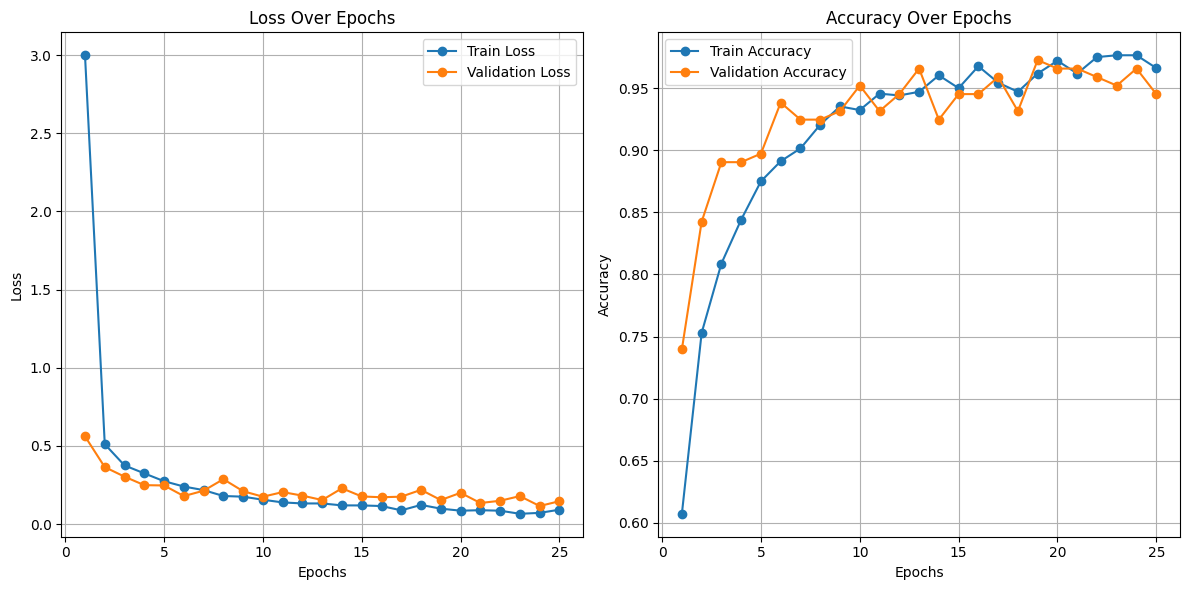

In [114]:
plot_training_progress(history)

In [115]:
# Evaluate on Test Data
model.eval()
correct_predictions = 0
total_predictions = 0
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    preds = torch.argmax(outputs, dim=1)
    correct_predictions += torch.sum(preds == labels.argmax(dim=1))  # Convert one-hot labels to class indices
    total_predictions += labels.size(0)

accuracy = correct_predictions.double() / total_predictions
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 95.21%


# Testing stuff

In [116]:
from IPython.display import Audio
import librosa

def predict_and_play_sound(file_path, model, le, device, target_sr=22050):
    """
    Loads an audio file, preprocesses it, predicts its class using the model,
    and plays the audio.

    Parameters:
    - file_path (str): Path to the audio file.
    - model (torch.nn.Module): Trained PyTorch model.
    - le (LabelEncoder): Fitted LabelEncoder to decode class labels.
    - device (torch.device): Device (CPU or GPU) where the model is loaded.
    - target_sr (int): Target sample rate for loading the audio.
    """
    # Load and preprocess the audio
    audio, sr = librosa.load(file_path, sr=target_sr)
    duration = librosa.get_duration(y=audio, sr=sr)
    print(f"Loaded audio file with duration: {duration:.2f}s")

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    mfccs_scaled = np.mean(mfccs.T, axis=0)
    mfccs_scaled = torch.tensor(mfccs_scaled, dtype=torch.float32).unsqueeze(0).unsqueeze(1).to(device)

    # Predict class
    model.eval()
    with torch.no_grad():
        outputs = model(mfccs_scaled)
        predicted_index = torch.argmax(outputs, dim=1).item()
        predicted_class = le.inverse_transform([predicted_index])[0]

    print(f"Predicted Class: {predicted_class}")

    # Play the sound
    print("Playing the audio...")
    return Audio(audio, rate=sr)


In [121]:
print("Test file paths:", test_paths[:10])

Test file paths: ['C:\\Users\\Krysia\\Desktop\\Other\\Projekty\\Machine Learning\\BoarSoundClassifier\\Model\\SoundData\\PreparedData\\NHU05040114_32.wav', 'C:\\Users\\Krysia\\Desktop\\Other\\Projekty\\Machine Learning\\BoarSoundClassifier\\Model\\SoundData\\PreparedData\\NHU05040114_20.wav', 'C:\\Users\\Krysia\\Desktop\\Other\\Projekty\\Machine Learning\\BoarSoundClassifier\\Model\\SoundData\\PreparedData\\07043401_6.wav', 'C:\\Users\\Krysia\\Desktop\\Other\\Projekty\\Machine Learning\\BoarSoundClassifier\\Model\\SoundData\\PreparedData\\NHU05095016_17.wav', 'C:\\Users\\Krysia\\Desktop\\Other\\Projekty\\Machine Learning\\BoarSoundClassifier\\Model\\SoundData\\PreparedData\\NHU05040109_33.wav', 'C:\\Users\\Krysia\\Desktop\\Other\\Projekty\\Machine Learning\\BoarSoundClassifier\\Model\\SoundData\\PreparedData\\07043401_29.wav', 'C:\\Users\\Krysia\\Desktop\\Other\\Projekty\\Machine Learning\\BoarSoundClassifier\\Model\\SoundData\\PreparedData\\07043093_8.wav', 'C:\\Users\\Krysia\\Desktop

In [ ]:
for audio_file in test_paths[:10]:
    audio_playback = predict_and_play_sound(audio_file, model, le, device)
    display(audio_playback)  # This will play the audio in a Jupyter Notebook

In [122]:
oos_data_path = 'C:\\Users\\Krysia\\Desktop\\Other\\Projekty\\Machine Learning\\BoarSoundClassifier\\Model\\test_data\\76796__robinhood76__01161-boar-oink-3.wav'

In [123]:
audio_playback = predict_and_play_sound(oos_data_path, model, le, device)
display(audio_playback)  # This will play the audio in a Jupyter Notebook

Loaded audio file with duration: 2.44s
Predicted Class: 0
Playing the audio...
